In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import transformer_lens
from pruned_tqs.Hamiltonian import Ising
from pruned_tqs.Hamiltonian_utils import dec2bin
from pruned_tqs.model_utils import sample, compute_psi
import pickle
import torch
import glob

c:\Users\durrc\OneDrive\Desktop\mech_interp_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Quickly evaluate the quality of learned states

In [2]:
run_title = 'ten_site_test'

In [4]:
with open(f"results/{run_title}/model_config.pkl", 'rb') as file:
    data = pickle.load(file)

cfg = transformer_lens.HookedTransformerConfig.from_dict(
    data
)

hooked_model = transformer_lens.HookedTransformer(cfg)

ckpts = glob.glob(f"results/{run_title}/model_*.ckpt")
assert len(ckpts)==1, "ambiguous checkpoint"

state_dict = torch.load(ckpts[0])

# Load the state dictionary into the model
hooked_model.load_state_dict(state_dict)



<All keys matched successfully>

Now compare the state to the correct state

In [64]:
assert hooked_model.system_size<16

## param value

Choose a param value

In [65]:
param=-1

In [76]:
L=hooked_model.system_size
N=2**L
ham=Ising(system_size=L, periodic=False)
ham.update_param(param)

tqs_state = np.zeros(N)

batch_size = 1000

hooked_model.eval()

for i in range(0, N, batch_size):
    j = min(N, i+batch_size)

    states = dec2bin(torch.arange(i, j), hooked_model.system_size)

    log_psi, _ = compute_psi(hooked_model, samples=states.T, symmetry=ham.symmetry)

    tqs_state[i:j]=log_psi.detach().numpy()


c:\Users\durrc\OneDrive\Desktop\mech_interp_project\quantum_mech_interp\pruned_tqs\Hamiltonian_utils.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  system_size = torch.tensor(system_size, dtype=torch.int64).reshape(-1)


In [77]:
log_psi

tensor([-4.0652, -4.0867, -4.0576, -4.0534, -4.0495, -4.0541, -3.9819, -4.0609,
        -4.0412, -4.0192, -4.1278, -4.1351, -4.0476, -4.0670, -4.0772, -4.0442,
        -4.0355, -4.0784, -3.9695, -3.9936, -4.0843, -4.0977, -4.1543, -3.4282],
       grad_fn=<LogBackward0>)

Now compute the actual value

In [81]:
ws, vs = np.linalg.eigh(ham.full_H(param=param).todense())
gs = np.abs(vs[:, 0])

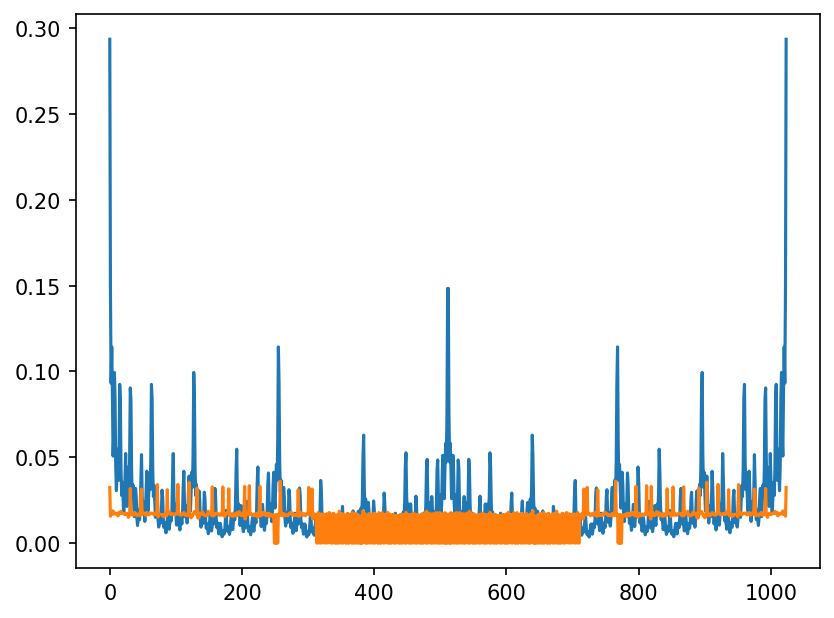

In [84]:
fig, ax = plt.subplots(dpi=150)

ax.plot(gs)
ax.plot(np.exp(tqs_state))

In [86]:
hooked_model.generate_state(param_values=(1, -1), system_size=4)

(tensor([[0., 0., 0., 1.]]), tensor([-1.6099]))